In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from scripts.plot import *

plot_params = set_plot_layout(path_to_latex = '/home/jklees/texlive/bin/x86_64-linux') # set plot layout (optional)C

# Reproducibility
np.random.seed(42)

from torchvision.datasets import CIFAR10
from torchvision import transforms

dataset = CIFAR10(
    root="./home/datasets/",
    train=False,
    download=True,
    transform=lambda x: np.array(x)
)

cifar_images = np.array([dataset[i][0] for i in range(len(dataset))])
cifar_labels = np.array([dataset[i][1] for i in range(len(dataset))])
cat_images = cifar_images[cifar_labels == 3]
dog_images = cifar_images[cifar_labels == 5]

Files already downloaded and verified


In [2]:

# --- Generate overlapping blobs ---
n = 300

mean_0 = np.array([-1.6, 0.0])
mean_1 = np.array([1.6, 0.0])
# cov = np.array([[1.0, 0.3],
#                 [0.3, 1.0]])
cov = np.array([[0.6, 0.1],
                [0.1, 0.6]])


X0 = np.random.multivariate_normal(mean_0, cov, n // 2)
X1 = np.random.multivariate_normal(mean_1, cov, n // 2)
X = np.vstack([X0, X1])

# --- Soft labels (probabilistic class membership) ---
# Distance-based posterior (smooth overlap)
def soft_label(x, m0, m1, temperature=1.0):
    d0 = np.linalg.norm(x - m0)
    d1 = np.linalg.norm(x - m1)
    return 1 / (1 + np.exp((d1 - d0) / temperature))

temperature = 4

probs = np.array([soft_label(x, mean_0, mean_1, temperature=temperature) for x in X])

# --- Custom teal → coral colormap ---
teal_coral = LinearSegmentedColormap.from_list(
    "teal_coral",
    ["#2a9d8f", "#f4a261"]
)



In [3]:
from scripts.probabilistic_label_spreading import prob_label_spreading
import pandas as pd
from IPython import get_ipython
# run the algorithm once
k = 10
n_data = "all"
data_space = "features"
prob_label_column = "prob_label" #  
alpha = 0.9
n_samples = 10
dataset_name = "TwoBlobs"

df = pd.DataFrame({
    "features": list(X),
    "prob_label": [ [probs.tolist()[i], 1 - probs.tolist()[i]] for i in range(len(probs))],
    "label": (probs >= 0.5).astype(int)
})

results, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples)

46  :  0 ,
172  :  0 ,
129  :  1 ,
94  :  1 ,
114  :  1 ,
242  :  0 ,
291  :  1 ,
281  :  0 ,
298  :  0 ,
282  :  0 ,


In [4]:
results

,dataset,n_data,dim_reduction_technique,dimension,prob_labels,alpha,n_samples,k,RMSE,Accuracy,KL,MAE,TV,runtime,config
0,TwoBlobs,300,features,2,prob_label,0.9,10,10,0.270212,0.9,0.435957,0.252816,0.252816,0.907673,configs/FGMRES.json


In [5]:
estimates = np.array( processed_data['p_hat'].tolist() )
feedback = np.array( processed_data['trials'].tolist() )

observations = {46  :  0 ,
172  :  0 ,
129  :  1 ,
94  :  1 ,
114  :  1 ,
242  :  0 ,
291  :  1 ,
281  :  0 ,
298  :  0 ,
282  :  0 ,}
labeled_idx = list(observations.keys())
y_obs = list(observations.values())

/tmp/ipykernel_26846/2874499982.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


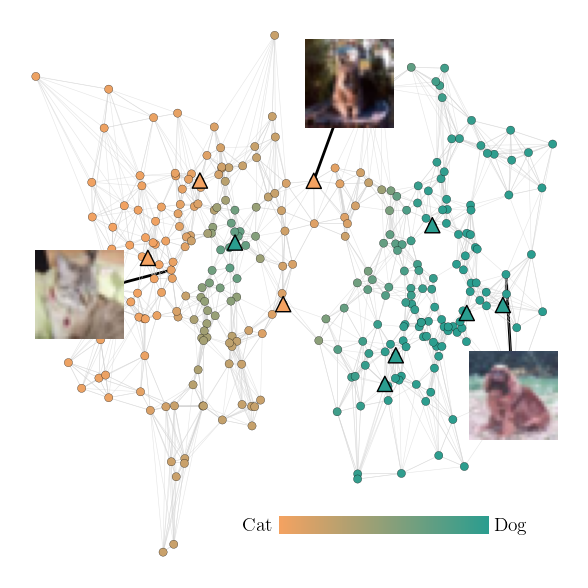

In [6]:
triangle_size = 120
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)

def imscatter(x, y, image, ax, zoom=0.4):
    """Attach an image to a scatter plot point."""
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)


# Example indices (replace with real selection logic)
cat_idx = np.argmin(probs)            # p ≈ 0
cat_img = cat_images[1]      # Example cat image
dog_img = dog_images[8] #0      # Example dog image
dog_idx = np.argmax(probs)            # p ≈ 1
amb_idx = np.argmin(np.abs(probs - 0.5))
amb_image = cat_images[6]  # Example ambiguous image

selected = [cat_idx, dog_idx, amb_idx]
selected_images = [cat_img, dog_img, amb_image]

fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot
sc = ax.scatter(
    X[:, 0],
    X[:, 1],
    c=estimates[:, 1], #probs
    cmap=teal_coral,
    s=35,
    linewidths=0.2,
    edgecolors="k", zorder = 3
)

# # Colorbar
# cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_label(r"$p(\mathrm{dog}\mid x)$", fontsize=11)

# Offsets for images (avoid overlap)
# offsets = [(-1.45, -0.2), (0.28, 0.35), (0.5, 0.45)]
offsets = [(-1.3, -0.2), (0.1, -1.0), (0.5, 0.8)]


for idx, img, (dx, dy) in zip(selected, selected_images, offsets):
    x, y = X[idx]

    # Connection line
    ax.plot([x, x + dx], [y, y + dy],
            color="black", linewidth=2.0)

    # Attach image (CIFAR image assumed shape (32,32,3))
    imscatter(
        x + dx,
        y + dy,
        img,   # <- your CIFAR-10 image here
        ax,
        zoom=2.0 # 1.5
    )

for i in range(n):
    for j in indices[i]:
        ax.plot([X[i, 0], X[j, 0]],
                [X[i, 1], X[j, 1]],
                color="lightgray", linewidth=0.4, alpha=0.6)

ax.scatter(X[labeled_idx, 0], X[labeled_idx, 1], marker="^",
           c=y_obs, cmap=teal_coral, s=triangle_size, edgecolor="black", zorder=3)

ax.set_xticks([])
ax.set_yticks([])
# ax.set_aspect('equal', adjustable='datalim')

ax.set_xticks([])
ax.set_yticks([])

plt.axis('off')

# Custom colorbar axis
cax = fig.add_axes([0.475, 0.1, 0.35, 0.03])
cax.axis("off")
cax.invert_xaxis()
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')

plt.text(-0.1, 0.45, 'Cat', va='center', ha='center', fontsize=14, transform=cax.transAxes)
plt.text(1.1, 0.45, 'Dog', va='center', ha='center', fontsize=14, transform=cax.transAxes)

plt.tight_layout()
plt.savefig("teaser-1.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

/tmp/ipykernel_26846/2101231314.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


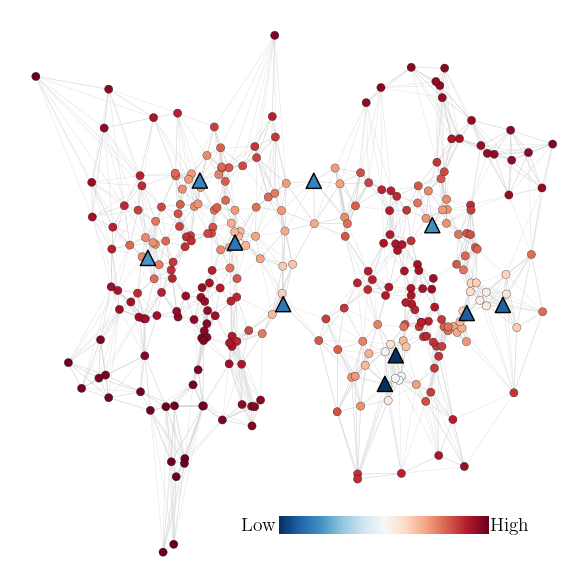

In [7]:
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=feedback.min(), vmax=feedback.max())

fig, ax = plt.subplots(figsize=(6, 6))

X_not_sampled = np.delete(X, labeled_idx, axis=0)
feedback_not_sampled = np.delete(feedback, labeled_idx, axis=0)
# Scatter plot
sc = ax.scatter(
    X_not_sampled[:, 0],
    X_not_sampled[:, 1],
    c=feedback_not_sampled, #probs
    cmap="RdBu",
    norm = norm,
    s=35,
    linewidths=0.2,
    edgecolors="k", zorder = 3
)

# # Offsets for images (avoid overlap)
# offsets = [(-1.4, -0.2), (0.4, 0.4), (0.6, 0.5)]

# for idx, img, (dx, dy) in zip(selected, selected_images, offsets):
#     x, y = X[idx]

#     # Connection line
#     ax.plot([x, x + dx], [y, y + dy],
#             color="gray", alpha=0.6, linewidth=1.0)

#     # Attach image (CIFAR image assumed shape (32,32,3))
#     imscatter(
#         x + dx,
#         y + dy,
#         img,   # <- your CIFAR-10 image here
#         ax,
#         zoom=1.25
#     )

for i in range(n):
    for j in indices[i]:
        ax.plot([X[i, 0], X[j, 0]],
                [X[i, 1], X[j, 1]],
                color="lightgray", linewidth=0.4, alpha=0.6)

# # Plot sampled data points
ax.scatter(X[labeled_idx, 0], X[labeled_idx, 1],
            c=feedback[labeled_idx], 
            cmap="RdBu",
            norm = norm,
            marker = "^",
            s=triangle_size, edgecolor="black", zorder=3)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks([])
ax.set_yticks([])

plt.axis('off')

# Custom colorbar axis
cax = fig.add_axes([0.475, 0.1, 0.35, 0.03])
cax.axis("off")
cax.invert_xaxis()
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')

plt.text(-0.1, 0.45, 'Low', va='center', ha='center', fontsize=14, transform=cax.transAxes)
plt.text(1.1, 0.45, 'High', va='center', ha='center', fontsize=14, transform=cax.transAxes)

plt.tight_layout()
plt.savefig("teaser-2.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()